In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy.stats import linregress

In [2]:
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (12, 3), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

In [3]:
def plot_bar(ax, configs, Ds, error_field, bar_width=0.2):
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(configs)))
    
    for idx, (label, df) in enumerate(configs):
        df = df[df['D'].isin(Ds)]
        df_by_D = df.groupby(['D'])[error_field]

        X_vals = np.arange(len(Ds))

        means = df_by_D.mean().values
        stds = df_by_D.std().values

        block_width = bar_width * len(configs)
        # each method is plotted len(X_vals) times for a dataset
        bar_positions = (X_vals * 2 * block_width) + block_width*(idx/(len(configs)-1))

        ax.bar(
            bar_positions,
            means,
            yerr=stds,
            error_kw=dict(lw=1, capsize=1, capthick=1),
            align='center',
            color = colors[idx],
            width = bar_width,
            label=label
        )

In [4]:
def plot_speed_lines(ax, configs, xlabel='', ylabel='', title=''):
    # colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(configs)))
    # print('D:', D)
    for i, config in enumerate(configs):
        color = config[1]
        D = config[2]['D'].values[:20]
        #print(D)
        res = linregress(D,config[2]['metric_time_ms'].values[:20])
        slope = res[0]
        offset = res[1]

        # ax.plot(D, config[1]['metric_time_ms'].values, label=config[0] + ' (Slope: {:.4f})'.format(slope), color=colors[i])
        ax.scatter(D, config[2]['metric_time_ms'].values[:20], label=config[0], color=color, marker='o')
        ax.plot(D, offset + slope * D, color=color, linewidth=3, linestyle='solid', alpha=1)
        
        # print(D, config[1]['metric_time_ms'].values)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=D[0], right=D[-1])
    ax.set_xticks(D[::3])
    ax.set_xticklabels(['{}d'.format(i) for i in range(1,len(D)+1,3)])
    #ax.set_title(title)

In [5]:
def scatter(ax, configs, field1, field2, xlabel='', ylabel='', title=''):
    # full cov
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(configs)))
    for i, config in enumerate(configs):
        D = config[2]['D'].values[:20]
        
        if config[0] == 'TensorSRHT':
            end_index = 20 # 40
        else:
            end_index = 20
            
        mask = config[2][field1].values > 0

        ax.plot(
            config[2][field1].values[mask][:end_index:1],
            config[2][field2].values[mask][:end_index:1],
            # s=30,
            marker='o',
            linewidth=3,
            label = config[0],
            color = config[1]
        )
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.set_xlim(left=0)
    
#     ax.set_ylim(bottom=0)
    ax.set_xlim(left=D[0], right=D[-1])
    ax.set_xticks(D[::3])
    ax.set_xticklabels(['{}d'.format(i) for i in range(1,len(D)+1,3)])
    if ylabel=='':
        ax.tick_params(axis='y', which='left', labelleft='off', left=False)
    #ax.set_title(title)

In [6]:
def ts_slope(D, p):
    # 1 FFT
    # N/2 log2(N) complex multiplies
    # N log2(N) complex additions
    # possibly needs only half of the operations because of rfft
    # https://cnx.org/contents/qAa9OhlP@2.44:zmcmahhR@7/Decimation-in-time-DIT-Radix-2-FFT#fig2
    flop_mul = D/2. * np.log2(D) * 4.
    flop_add = D * np.log2(D) * 2.
    flop_fft = flop_mul + flop_add
    
    flop_mult = D*4
    
    return (p+1) * flop_fft + (p-1) * flop_mult

In [7]:
def srht_slope(D, d, p, complex_weights=False):
    # 1 FFT
    flop_mul = d/2. * np.log2(d) * 4.
    flop_add = d * np.log2(d) * 2.
    flop_fft = flop_mul + flop_add
    
    flop_mult = D*4
    
    return p * flop_fft + (p-1) * flop_mult

## MNIST normal p=3

In [8]:
colors = plt.get_cmap('tab20c')(np.linspace(0, 0.8, 16))[::2]
colors = np.flip(colors, axis=0)

In [11]:
# df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias1_mnist.csv')
df = pd.read_csv('../csv/time_benchmark/rep100_p3_bias0.5_len_1.41_mnist.csv')

configs_p3 = [
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)])
#     ('TensorSRHT-IB', df[(df['proj'] == 'srht') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == False)]),
#     ('C-TensorSRHT-IB', df[(df['proj'] == 'srht') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == True)]),
    ('SRF', colors[5], df[(df['proj'] == 'srf')]),
    ('TensorSketch', colors[4], df[(df['proj'] == 'countsketch_scatter')]),
    ('Rademacher', colors[3], df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == False)]),
    ('CtR-ProductSRHT', colors[7], df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)]),
    ('ProductSRHT', colors[6], df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),


]

In [10]:
df = pd.read_csv('../csv/time_benchmark/rep100_p6_bias1_mnist.csv')

configs_p6 = [
#     ('Rademacher comp..', df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == True)])
#     ('TensorSRHT-IB', df[(df['proj'] == 'srht') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == False)]),
#     ('C-TensorSRHT-IB', df[(df['proj'] == 'srht') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == True)]),
    ('ProductSRHT', colors[6], df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == False)]),
    ('CtR-ProductSRHT', colors[7], df[(df['proj'] == 'srht') & (df['full_cov'] == True) & (df['complex_real'] == True)]),
    ('Rademacher', colors[3], df[(df['proj'] == 'rademacher') & (df['full_cov'] == False) & (df['complex_real'] == False) & (df['complex_weights'] == False)]),
    ('TensorSketch', colors[4], df[(df['proj'] == 'countsketch_scatter')])
]

In [ ]:
# rep100_p3_bias0.5_len_1.41_mnist.csv

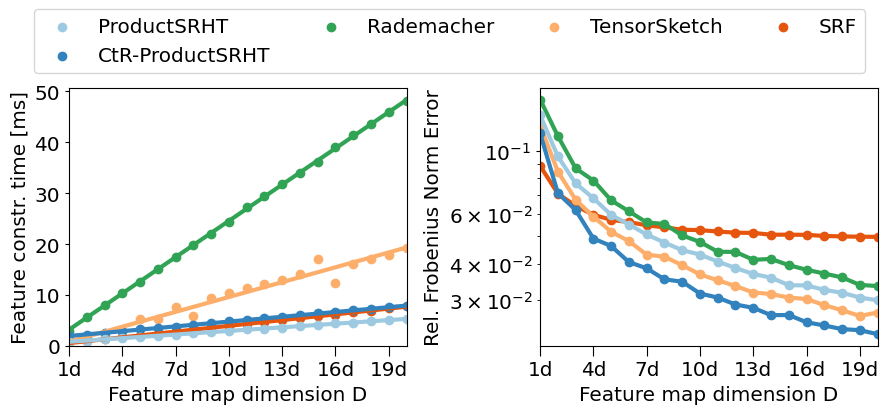

In [13]:
# run on Tesla T4

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3.5))
# Ds = [i*1024 for i in range(1, 21, 2)]

plot_speed_lines(axes[0], configs_p3, xlabel='Feature map dimension D', ylabel='Feature constr. time [ms]', title=r'$p=3$')
scatter(axes[1], configs_p3, 'D', 'frob_mean', xlabel='Feature map dimension D', ylabel='Rel. Frobenius Norm Error', title=r'$p=3$')
#scatter(axes[2], configs_p6, 'metric_time_ms', 'frob_mean', xlabel='Time [ms]', title=r'$p=6$')
# plot_bar(axes[0], configs, Ds, 'frob_mean', bar_width=0.2)
handles, labels = axes[0].get_legend_handles_labels()
handles = list(reversed(handles))
labels = list(reversed(labels))

plt.tight_layout()

legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.35,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/frob_vs_speed_mnist_p3.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

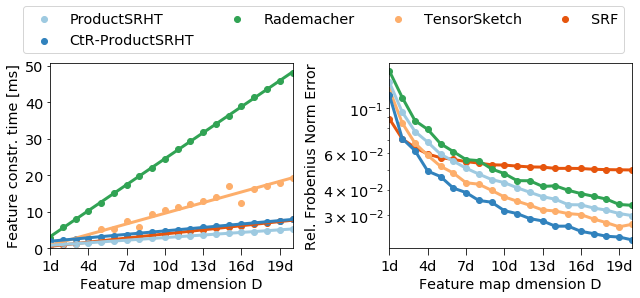

In [53]:
# run on Tesla T4

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3.5))
# Ds = [i*1024 for i in range(1, 21, 2)]

plot_speed_lines(axes[0], configs_p3, xlabel='Feature map dimension D', ylabel='Feature constr. time [ms]', title=r'$p=3$')
scatter(axes[1], configs_p3, 'D', 'frob_mean', xlabel='Feature map dimension D', ylabel='Rel. Frobenius Norm Error', title=r'$p=3$')
#scatter(axes[2], configs_p6, 'metric_time_ms', 'frob_mean', xlabel='Time [ms]', title=r'$p=6$')
# plot_bar(axes[0], configs, Ds, 'frob_mean', bar_width=0.2)
handles, labels = axes[0].get_legend_handles_labels()
handles = list(reversed(handles))
labels = list(reversed(labels))

plt.tight_layout()

legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.35,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/frob_vs_speed_mnist_p3.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

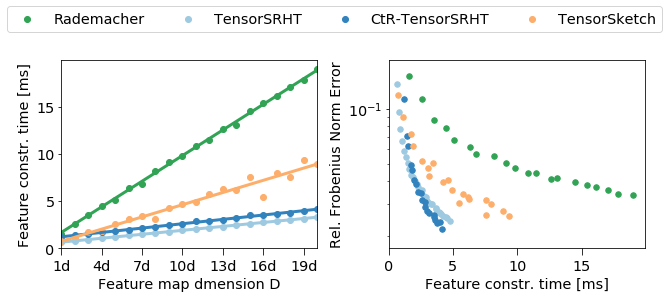

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3.5))
# Ds = [i*1024 for i in range(1, 21, 2)]

plot_speed_lines(axes[0], configs_p3, xlabel='Feature map dmension D', ylabel='Feature constr. time [ms]', title=r'$p=3$')
scatter(axes[1], configs_p3, 'metric_time_ms', 'frob_mean', xlabel='Feature constr. time [ms]', ylabel='Rel. Frobenius Norm Error', title=r'$p=3$')
#scatter(axes[2], configs_p6, 'metric_time_ms', 'frob_mean', xlabel='Time [ms]', title=r'$p=6$')
# plot_bar(axes[0], configs, Ds, 'frob_mean', bar_width=0.2)
handles, labels = axes[0].get_legend_handles_labels()
plt.tight_layout()

legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.35,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/frob_vs_speed_mnist_p3.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

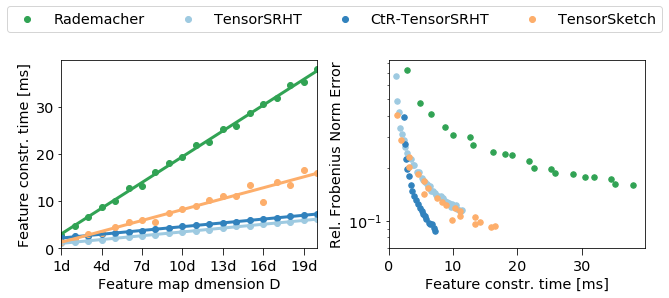

In [52]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3.5))
# Ds = [i*1024 for i in range(1, 21, 2)]

plot_speed_lines(axes[0], configs_p6, xlabel='Feature map dmension D', ylabel='Feature constr. time [ms]', title=r'$p=6$')
scatter(axes[1], configs_p6, 'metric_time_ms', 'frob_mean', xlabel='Feature constr. time [ms]', ylabel='Rel. Frobenius Norm Error', title=r'$p=6$')
#scatter(axes[2], configs_p6, 'metric_time_ms', 'frob_mean', xlabel='Time [ms]', title=r'$p=6$')
# plot_bar(axes[0], configs, Ds, 'frob_mean', bar_width=0.2)
handles, labels = axes[0].get_legend_handles_labels()
plt.tight_layout()

legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.35,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/frob_vs_speed_mnist_p6.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

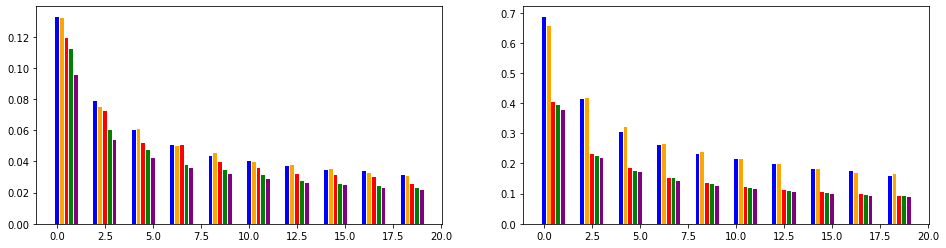

In [162]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))

plot_bar(axes[0], configs_p3, Ds, 'frob_mean', bar_width=0.2)
plot_bar(axes[1], configs_p6, Ds, 'frob_mean', bar_width=0.2)